In [1]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tf2onnx
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Dataset

In [2]:
# !wget -O dataset.zip https://chmura.put.poznan.pl/s/LxYSsota5PCbXcU/download
# !mkdir dataset_jetbot
# !unzip dataset.zip
# !rm dataset/1652875851.3497071/0199.jpg

In [3]:
def preprocess_image(img):
    img = cv2.resize(img, (128, 128))
    return np.array(img).astype(np.float32) / 255

In [4]:
def create_dataset(img_folder):
    X, y = [], []
    for dir1 in os.listdir(img_folder):
        if '.csv' not in dir1:
            csv = pd.read_csv(os.path.join(img_folder, dir1 + '.csv'), sep=',', header=None)
            for row in csv.iterrows():
                y.append((row[1][1], row[1][2]))
            for file in sorted(os.listdir(os.path.join(img_folder, dir1))):
                image = cv2.imread(os.path.join(img_folder, dir1, file), cv2.COLOR_BGR2RGB)
                X.append(preprocess_image(image))

    return np.array(X), np.array(y)

In [5]:
X, y = create_dataset('./dataset/')
X.shape, y.shape

((7584, 128, 128, 3), (7584, 2))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5308, 128, 128, 3), (2276, 128, 128, 3), (5308, 2), (2276, 2))

### Augmentation

[0.6875    0.9921875]


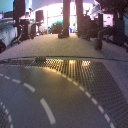

In [7]:
print(y[72])
Image.fromarray(np.array(X[72] * 255).astype(np.uint8))

In [8]:
def brightness_augment(img):
    img = np.array(img * 255).astype(np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[:, :, 2] = hsv[:, :, 2] * (np.random.normal(1.0, 0.6))
    hsv[:, :, 2][hsv[:, :, 2] > 255] = 255
    hsv[:, :, 2][hsv[:, :, 2] < 0] = 0
    rgb = cv2.cvtColor(np.array(hsv, dtype=np.uint8), cv2.COLOR_HSV2RGB)
    return rgb.astype(np.float32) / 255

[0.6875    0.9921875]


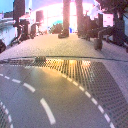

In [9]:
print(y[72])
Image.fromarray(np.array(brightness_augment(X[72]) * 255).astype(np.uint8))

In [10]:
def flip_augment(img):
    return cv2.flip(img, 1)

def flip_label(label):
    return (label[0], -label[1])

(0.6875, -0.9921875)


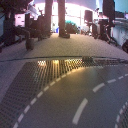

In [11]:
print(flip_label(y[72]))
Image.fromarray(np.array(flip_augment(X[72]) * 255).astype(np.uint8))

In [12]:
X_aug, y_aug = [], []
for xi, yi in zip(X_train, y_train):
    bright1 = brightness_augment(xi)
    flip1 = flip_augment(xi)
    flip2 = flip_augment(bright1)

    X_aug.append(bright1)
    y_aug.append(yi)
    X_aug.append(flip1)
    y_aug.append(flip_label(yi))
    X_aug.append(flip2)
    y_aug.append(flip_label(yi))

X_aug, y_aug = np.array(X_aug), np.array(y_aug)
X_aug.shape, y_aug.shape

((15924, 128, 128, 3), (15924, 2))

In [13]:
X_train, y_train = np.concatenate([X_train, X_aug]), np.concatenate([y_train, y_aug])
X_train, y_train = shuffle((X_train, y_train), random_state=23)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21232, 128, 128, 3), (2276, 128, 128, 3), (21232, 2), (2276, 2))

### Model

In [14]:
base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(2, activation='tanh')(x)

model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [15]:
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mae'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 8, 8, 512)         262144    
                                                                 
 conv_pw_9

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=7, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_mae", factor=0.1, patience=3, min_lr=0.0001)
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

Epoch 1/100
664/664 [==============================] - 91s 135ms/step - loss: 0.3541 - mae: 0.3639 - val_loss: 0.2256 - val_mae: 0.2779 - lr: 0.1000
Epoch 2/100
664/664 [==============================] - 136s 205ms/step - loss: 0.2315 - mae: 0.2902 - val_loss: 0.2226 - val_mae: 0.2802 - lr: 0.1000
Epoch 3/100
664/664 [==============================] - 93s 140ms/step - loss: 0.2278 - mae: 0.2898 - val_loss: 0.2144 - val_mae: 0.2858 - lr: 0.1000
Epoch 4/100
664/664 [==============================] - 92s 138ms/step - loss: 0.2225 - mae: 0.2880 - val_loss: 0.2086 - val_mae: 0.2682 - lr: 0.1000
Epoch 5/100
664/664 [==============================] - 91s 137ms/step - loss: 0.2162 - mae: 0.2804 - val_loss: 0.1865 - val_mae: 0.2562 - lr: 0.1000
Epoch 6/100
664/664 [==============================] - 93s 140ms/step - loss: 0.2086 - mae: 0.2727 - val_loss: 0.1959 - val_mae: 0.2637 - lr: 0.1000
Epoch 7/100
664/664 [==============================] - 92s 139ms/step - loss: 0.1999 - mae: 0.2674 - val_

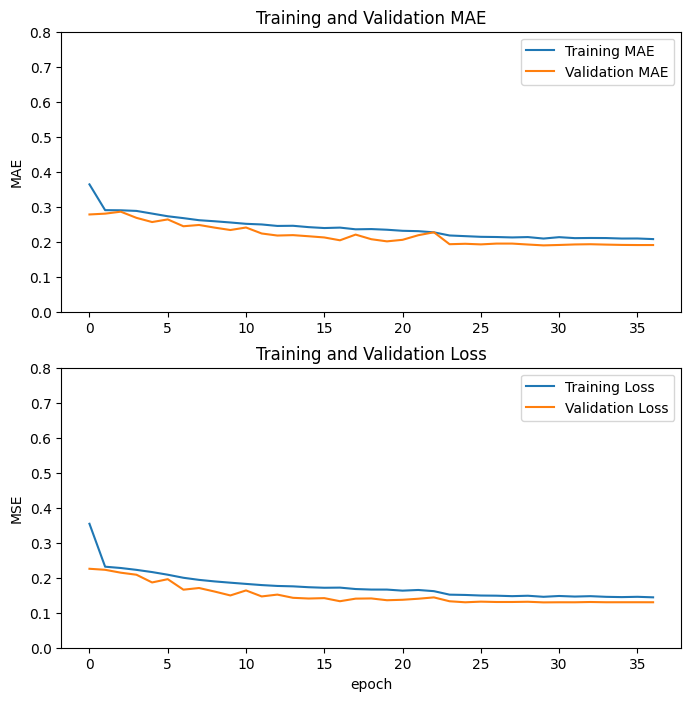

In [18]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend(loc='upper right')
plt.ylabel('MAE')
plt.ylim([0, 0.8])
plt.title('Training and Validation MAE')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('MSE')
plt.ylim([0, 0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 344ms/step
[[ 0.97882426 -0.78371775]]
[1.        0.9921875]


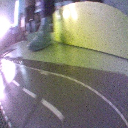

In [19]:
idx = 1000

print(model.predict(X_test[idx][np.newaxis, ...]))
print(y_test[idx])
Image.fromarray(np.asarray(X_test[idx] * 255).astype(np.uint8))

In [20]:
final_mae = model.evaluate(X_test, y_test)[1]

72/72 [==============================] - 9s 131ms/step - loss: 0.1295 - mae: 0.1895


In [21]:
model.save(f"./models/mobile_net_{final_mae:0.3f}")

INFO:tensorflow:Assets written to: ./models/mobile_net_0.190\assets


INFO:tensorflow:Assets written to: ./models/mobile_net_0.190\assets


In [23]:
spec = (tf.TensorSpec((None, 128, 128, 3), tf.float32, name="input"),)
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=11,
                                            output_path=f"onnx/mobile_net_{final_mae:0.3f}.onnx")